<a href="https://colab.research.google.com/github/forexms78/AI-05-/blob/main/%EB%AF%B8%EC%85%983_2%ED%8C%80_%EB%B0%95%EB%B3%91%ED%98%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 자전거 대여 시스템 데이터 분석

1. 자전거 대여 패턴을 분석
2. 자전거 배치 및 운영 전략 최적화
3. 대여 수요를 정확하게 예측
4. 대여 시스템의 효율 성 높이기
5. 사용자의 만족도를 증가
6. RMSLE (Root Mean Squared Logarithmic Error)를 최대한 낮추기


7:3 8:2 학습

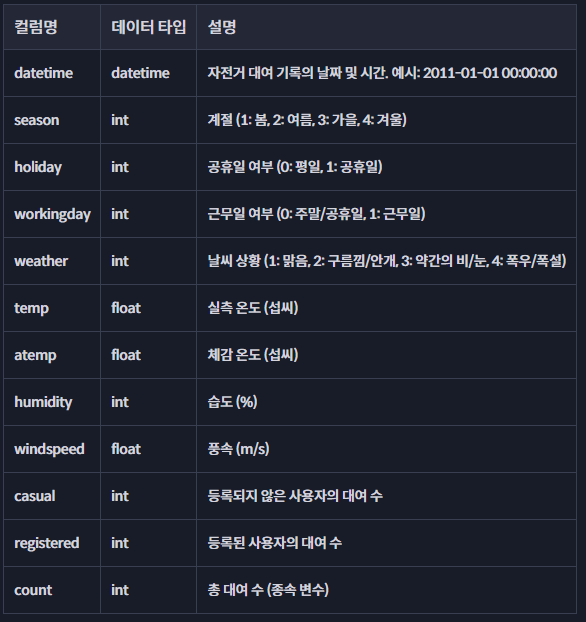

train.csv 파일에는 count 컬럼이 포함되어 있으며, 예측 대상인 종속 변수입니다.
test.csv 파일에는 casual, registered, count 컬럼이 포함되어 있지 않습니다.
casual과 registered는 자전거 대여 수요를 예측하는데 참고하실만한 자료이며, count는 두 컬럼간의 합입니다.
예시 분석 질문
어떤 방향으로 분석해야 할지 고민되신다면, 예시 질문들을 바탕으로 다양한 관점에서 데이터를 탐색하고 분석해보세요.

특정 시간대의 자전거 대여 패턴은 무엇인가요?
날씨 변수와 자전거 대여 수요 간의 상관관계는 무엇인가요?
계절별 자전거 대여 패턴의 차이는 무엇인가요?
주말과 평일의 자전거 대여 수요 차이는 무엇인가요?
자전거 대여 수요를 예측하기 위해 사용할 수 있는 가장 중요한 변수는 무엇인가요?
자전거 대여 수요 예측 모델을 구축하고, 이를 기반으로 한 운영 전략을 제안해보세요.
제출 내용
분석과정 및 분석 결과가 포함된 Colab Notebook
가설, 분석의 전개, 인사이트 등이 포함된 보고서

In [68]:
# 데이터 불러오기

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
# train 데이터 및 test 데이터 불러오

import pandas as pd
train = pd.read_csv('/content/drive/MyDrive/ai05/train1.csv')
test = pd.read_csv('/content/drive/MyDrive/ai05/test1.csv')

In [70]:
# EDA 컬럼 전처리

train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(train['datetime'])

train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['weekday'] = train['datetime'].dt.weekday

test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour
test['weekday'] = test['datetime'].dt.weekday

In [71]:
# 전처리

train = train.drop(['casual', 'registered', 'datetime'], axis=1)
test = test.drop(['datetime'], axis=1)

In [72]:
print(train.columns)

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'count', 'year', 'month', 'day', 'hour',
       'weekday'],
      dtype='object')


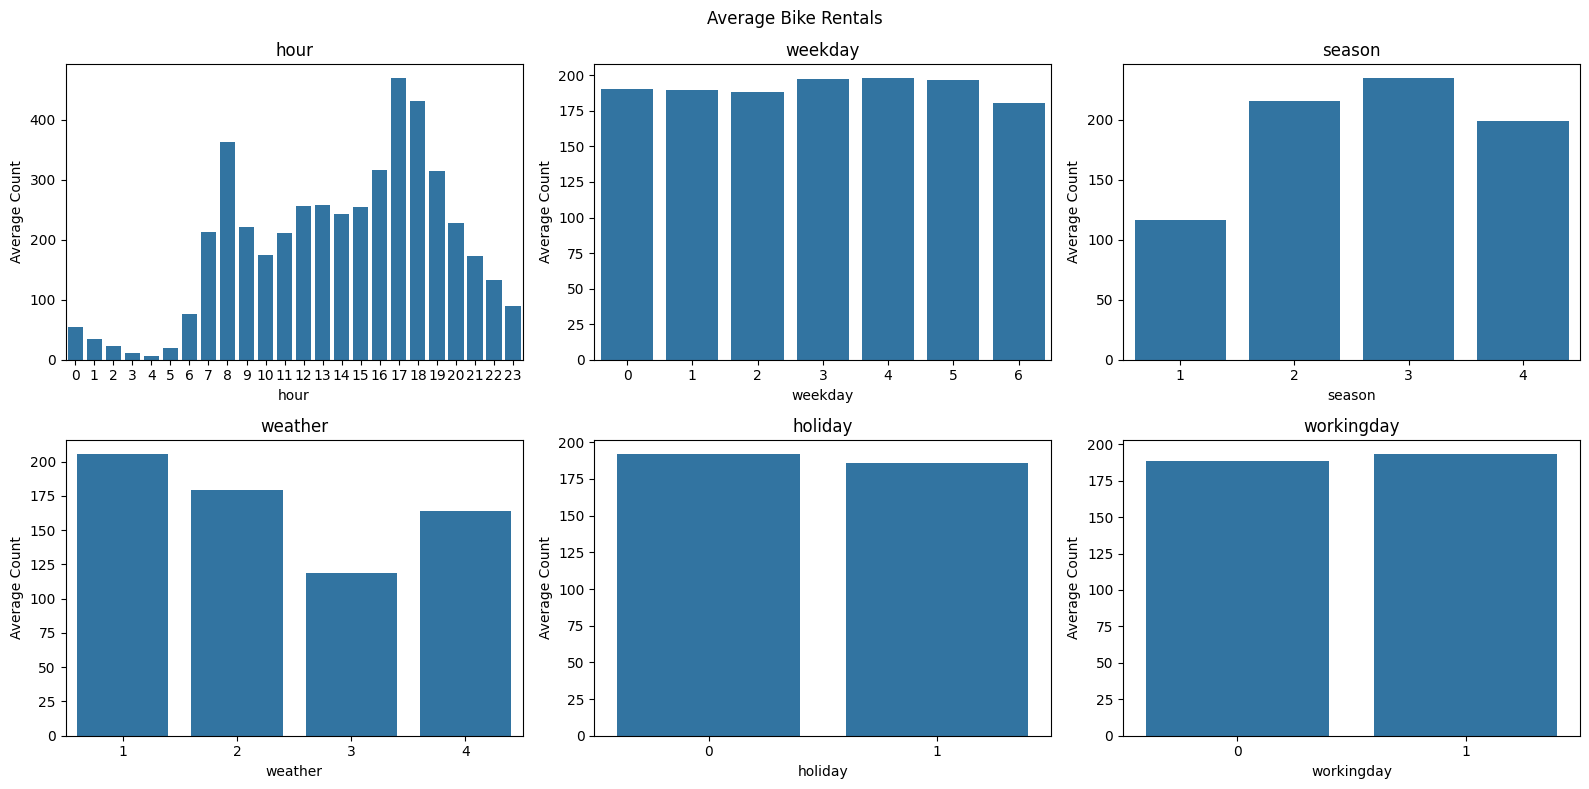

In [73]:
# 시간대별 평균 자전거 대여량 시각화

import matplotlib.pyplot as plt
import seaborn as sns

features = ['hour', 'weekday', 'season', 'weather', 'holiday', 'workingday']

fig, axes = plt.subplots(nrows=2,ncols=3, figsize=(16,8))
fig.suptitle('Average Bike Rentals')

for i , feature in enumerate(features):
  row = i // 3
  col = i % 3

  avg_counts = train.groupby(feature)['count'].mean()

  sns.barplot(x=avg_counts.index, y=avg_counts.values, ax=axes[row,col])
  axes[row,col].set_xlabel(feature)
  axes[row,col].set_ylabel('Average Count')
  axes[row,col].set_title(f'{feature}')

plt.tight_layout()
plt.show()


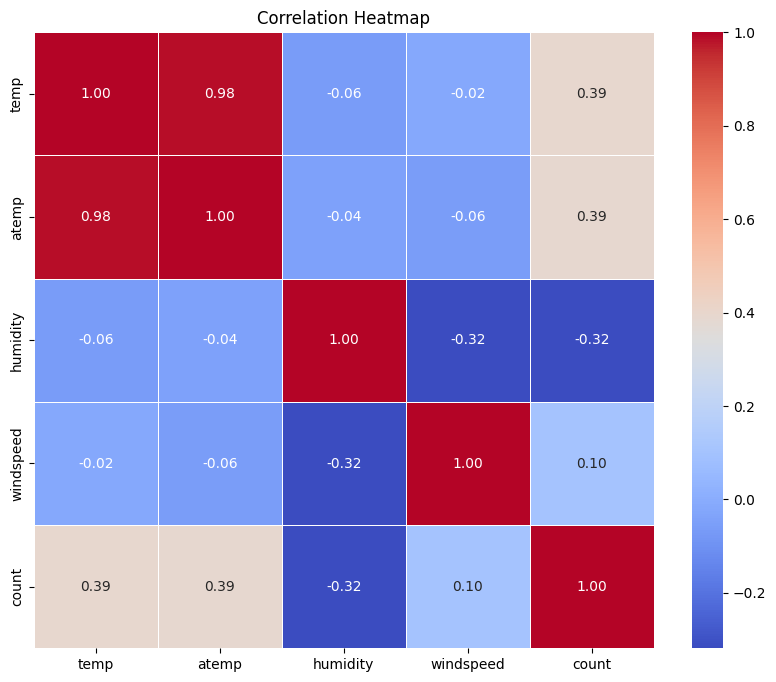

In [74]:
# 히트맵으로 그려보기

import matplotlib.pyplot as plt
import seaborn as sns

features = ['temp', 'atemp', 'humidity', 'windspeed','count']

corr_matrix = train[features].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()


In [75]:
# 중복된 행의 수

print(f"중복된 행 수: {train.duplicated().sum()}")

중복된 행 수: 0


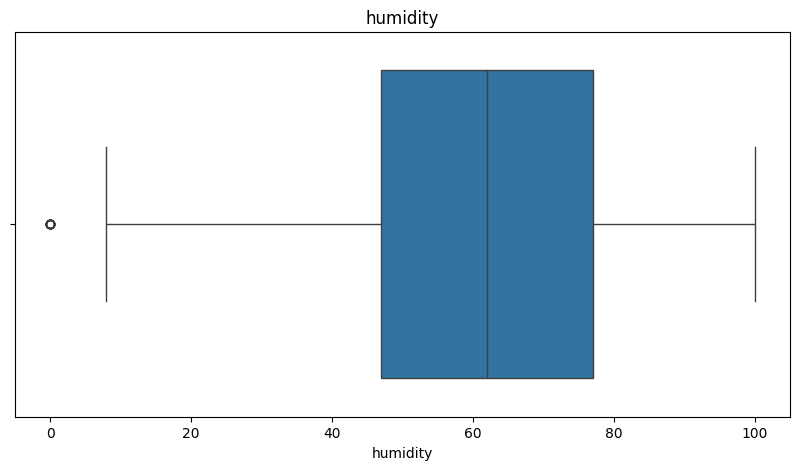

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.boxplot(x=train['humidity'])
plt.title('humidity')
plt.show()

In [77]:
# 습도가 0이거나 풍속이 0 인 데이터수 확인

print(f"습도가 0인 데이터 수 : {len(train[train['humidity'] == 0])}")
print(f"풍속이 0인 데이터 수 : {len(train[train['windspeed'] == 0])}")

습도가 0인 데이터 수 : 22
풍속이 0인 데이터 수 : 1313


In [78]:
# 습도를 중앙값으로 대체하기

humidity_zero = train[train['humidity'] == 0].index

humidity_mid = train['humidity'].median()

train.loc[humidity_zero, 'humidity'] = humidity_mid

print(f"습도가 0인 데이터 수 : {len(train[train['humidity'] == 0])}")

습도가 0인 데이터 수 : 0


In [79]:
# 풍속을 중앙값으로 대체하기

windspeed_zero =  train[train['windspeed'] == 0].index

windspeed_mid = train['windspeed'].median()

train.loc[windspeed_zero, 'windspeed'] = windspeed_mid

print(f"풍속이 0인 데이터 수 : {len(train[train['windspeed'] == 0])}")

풍속이 0인 데이터 수 : 0


In [80]:
# 폭우/폭설시 자전거 대여 수

print(f"train 데이터의 weather 4인 경우: {len(train[train['weather']==4])}건")
print(f"test 데이터의 weather 4인 경우: {len(test[test['weekday'] == 4])}건")

train 데이터의 weather 4인 경우: 1건
test 데이터의 weather 4인 경우: 929건


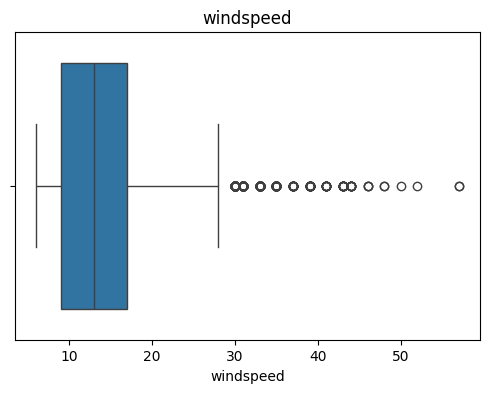

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.boxplot(x=train['windspeed'])
plt.title('windspeed')
plt.show()

In [82]:
# 풍속을 값을 학습할때 35정도를 최대값으로 설정

train['windspeed'] = train['windspeed'].apply(lambda x: 30 if x > 30 else x)
test['windspeed'] = test['windspeed'].apply(lambda x: 30 if x > 30 else x)

print(f"train['windspeed'] : {train['windspeed'].max()}")
print(f"test['windspeed'] : {test['windspeed'].max()} ")

train['windspeed'] : 30.0
test['windspeed'] : 30.0 


/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)


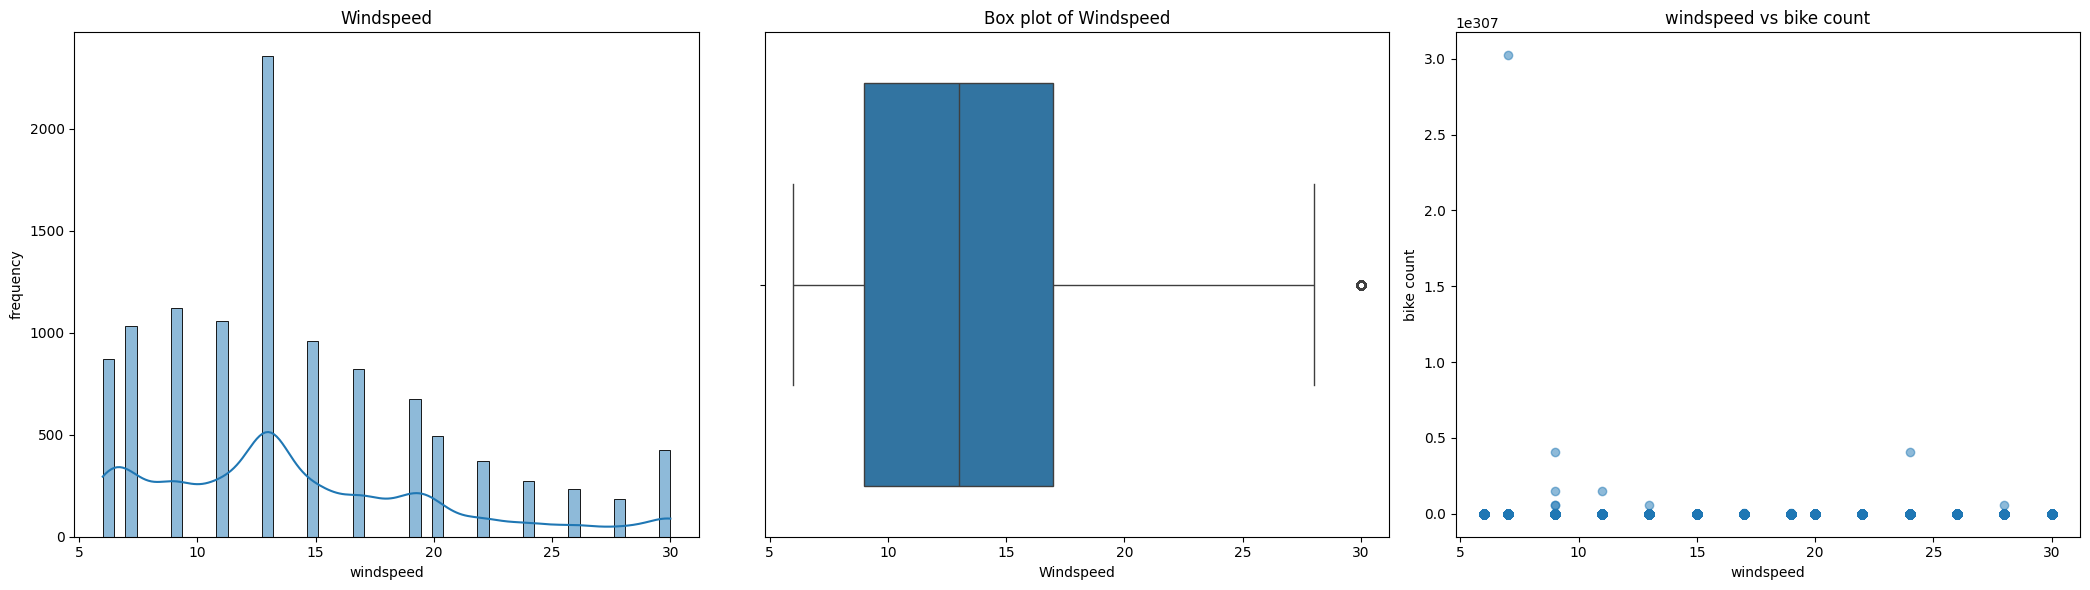

In [83]:
# 풍속 시각화하기

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(21,6))

sns.histplot(train['windspeed'], bins=50, kde=True, ax=ax1)
ax1.set_title('Windspeed')
ax1.set_xlabel('windspeed')
ax1.set_ylabel('frequency')

sns.boxplot(x=train['windspeed'], ax=ax2)
ax2.set_title('Box plot of Windspeed')
ax2.set_xlabel('Windspeed')

ax3.scatter(train['windspeed'], np.expm1(train['count']), alpha=0.5)
ax3.set_title('windspeed vs bike count')
ax3.set_xlabel('windspeed')
ax3.set_ylabel('bike count')

plt.tight_layout()
plt.show()

In [84]:
# 타켓 변수를 log로 변환하기

import numpy as np

train['count'] = np.log1p(train['count'])

In [85]:
# 독립 변수 종속변수 분리

y_train = train['count']
X_train = train.drop('count', axis=1)

In [86]:
# 데이터셋은 종속변수 없으므로 그대로 진행

X_test = test

In [87]:
# 범주형 변수 원-핫 인코딩

categorical_features = ['year', 'month', 'day', 'hour', 'weekday', 'season', 'weather', 'holiday', 'workingday']
X_train_encoded = pd.get_dummies(X_train, columns=categorical_features, prefix=categorical_features)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_features, prefix=categorical_features)

In [88]:
# train test 데이터셋 컬럼일치

common_cols = list(set(X_train_encoded.columns) & set(X_test_encoded.columns))
X_train_final = X_train_encoded[common_cols]
X_test_final = X_test_encoded[common_cols]

In [89]:
# 수치형 변수 스케일링

from sklearn.preprocessing import StandardScaler

numerical_features = ['temp', 'atemp', 'humidity', 'windspeed']
scaler = StandardScaler()
X_train_final[numerical_features] = scaler.fit_transform(X_train_final[numerical_features])
X_test_final[numerical_features] = scaler.fit_transform(X_test_final[numerical_features])

In [90]:
# 모델 학습

from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_final, y_train)

LinearRegression()

In [91]:
# RMSLE 계산 함수 생성

from sklearn.metrics import mean_squared_error

def rmsle(y_true, y_pred):
  y_pred[y_pred < 0] = 0
  return np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))

In [92]:
# 예측 및 RMSLE 점수 출력

train_predictions = model.predict(X_train_final)

In [93]:
# 예측값 제한 오버플로 방지를 위해 예측값을 18 이하로 제한

train_predictions[train_predictions > 18] = 18

rmsle_score = rmsle(np.expm1(y_train), np.expm1(train_predictions))
print(f"RMSLE: {rmsle_score:.4f}")

RMSLE: 0.5763


In [94]:
# 풍속을 처리할떄 숫자로인해서 RMSLE스코어 값이 많이달라진다
